# OUR TRY, E DAJE


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Modifica questo con il percorso alla tua cartella
data_dir = r"C:\Users\User\Desktop\Stat learning HW\Project\binary_one_type_split"

# Dimensione standard, modificabile
image_size = 256

# Trasformazioni da applicare: resize, tensorizzazione e normalizzazione
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # converte in [0,1]
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # per 3 canali
])

# Dataset per train e validation
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)

# DataLoader per batch
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


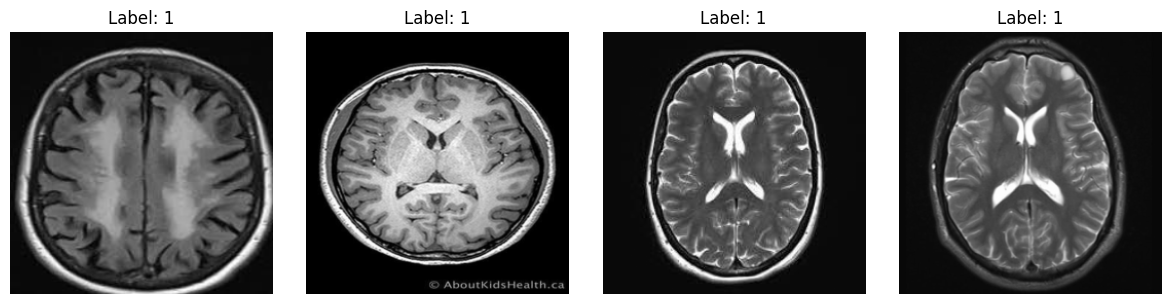

In [ ]:
import matplotlib.pyplot as plt
import torch

# Recupera un batch
images, labels = next(iter(train_loader))

# Riporta in [0,1] per visualizzare
images = images * 0.5 + 0.5

# Mostra le prime 4 immagini
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i].permute(1, 2, 0).squeeze()  
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()


In [3]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),    # (32, 128, 128)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # (64, 64, 64)
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 32, 32)
            nn.BatchNorm2d(128),  
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*32*32, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*32*32),
            nn.ReLU(),
            nn.Unflatten(1, (128, 32, 32)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (64, 64, 64)
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # (32, 128, 128)
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # (3, 256, 256)
            nn.Tanh()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=128).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [26]:
num_epochs = 200  # o anche 500, senza paura
patience = 10       # numero di epoche senza miglioramento prima di fermarsi
min_delta = 0.001   # soglia minima di miglioramento
best_loss = float('inf')
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Early stopping check
    if best_loss - epoch_loss > min_delta:
        best_loss = epoch_loss
        trigger_times = 0  # reset counter se migliora abbastanza
    else:
        trigger_times += 1
        print(f"🔁 Nessun miglioramento significativo ({trigger_times}/{patience})")

        if trigger_times >= patience:
            print("🛑 Early stopping attivato!")
            break



Epoch [1/200], Loss: 0.2909
Epoch [2/200], Loss: 0.1211
Epoch [3/200], Loss: 0.1071
Epoch [4/200], Loss: 0.0991
Epoch [5/200], Loss: 0.0963
Epoch [6/200], Loss: 0.0934
Epoch [7/200], Loss: 0.0894
Epoch [8/200], Loss: 0.0863
Epoch [9/200], Loss: 0.0833
Epoch [10/200], Loss: 0.0807
Epoch [11/200], Loss: 0.0783
Epoch [12/200], Loss: 0.0753
Epoch [13/200], Loss: 0.0715
Epoch [14/200], Loss: 0.0679
Epoch [15/200], Loss: 0.0644
Epoch [16/200], Loss: 0.0598
Epoch [17/200], Loss: 0.0560
Epoch [18/200], Loss: 0.0518
Epoch [19/200], Loss: 0.0477
Epoch [20/200], Loss: 0.0447
Epoch [21/200], Loss: 0.0433
Epoch [22/200], Loss: 0.0390
Epoch [23/200], Loss: 0.0362
Epoch [24/200], Loss: 0.0342
Epoch [25/200], Loss: 0.0322
Epoch [26/200], Loss: 0.0299
Epoch [27/200], Loss: 0.0289
🔁 Nessun miglioramento significativo (1/10)
Epoch [28/200], Loss: 0.0276
Epoch [29/200], Loss: 0.0258
Epoch [30/200], Loss: 0.0247
Epoch [31/200], Loss: 0.0240
🔁 Nessun miglioramento significativo (1/10)
Epoch [32/200], Loss: 

In [28]:
torch.save(model.state_dict(), "autoencoder.pth")


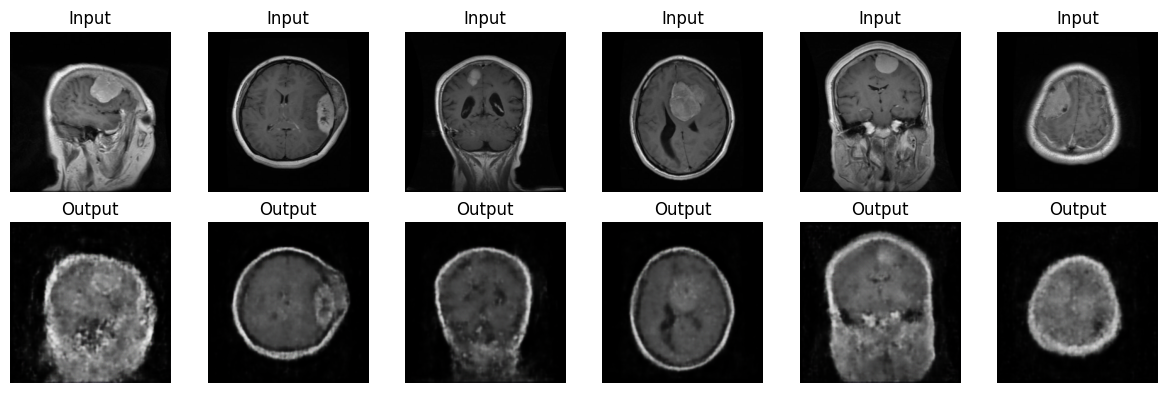

In [27]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images)

    # De-normalizza da [-1, 1] a [0, 1]
    inputs = images * 0.5 + 0.5
    recons = outputs * 0.5 + 0.5

    # Mostra alcune immagini originali e ricostruite
    fig, axes = plt.subplots(2, 6, figsize=(12, 4))
    for i in range(6):
        # Permuta per passare da [C, H, W] a [H, W, C]
        axes[0, i].imshow(inputs[i].cpu().permute(1, 2, 0).numpy())
        axes[0, i].set_title("Input")
        axes[0, i].axis("off")

        axes[1, i].imshow(recons[i].cpu().permute(1, 2, 0).numpy())
        axes[1, i].set_title("Output")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()



In [29]:
torch.save(model, "autoencoder_complete.pth")


In [4]:
# Ricrea l'istanza del modello
model = Autoencoder(latent_dim=128)
model.load_state_dict(torch.load("autoencoder.pth"))
model.eval()  


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=131072, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 32, 32))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [5]:
class TumorClassifier(nn.Module):
    def __init__(self, encoder, latent_dim=128):
        super().__init__()
        # Congela l'encoder, tranne ultimo layer
        for param in encoder.parameters():
            param.requires_grad = False
        
        for param in encoder[-2:].parameters():
            param.requires_grad = True

        self.encoder = encoder  # encoder già addestrato

        # Head di classificazione
        self.classifier = nn.Sequential(
                    nn.Linear(latent_dim, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    
                    nn.Linear(128, 64),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    nn.Dropout(0.3),
                    
                    nn.Linear(64, 1)
                )

    def forward(self, x):
        z = self.encoder(x)  # ottieni le feature compresse
        return self.classifier(z)


In [9]:
encoder = model.encoder

# Crea il classificatore completo
classifier_model = TumorClassifier(encoder, latent_dim=128).to(device)

In [11]:
from collections import Counter
print(Counter(train_dataset.targets))
print(Counter(test_dataset.targets))


Counter({1: 1600, 0: 1420})
Counter({1: 400, 0: 355})


In [16]:
classifier_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = classifier_model(images)
        probs = torch.sigmoid(outputs)

        print("Output raw logits:", outputs[:10].cpu().numpy().flatten())
        print("Probabilities:", probs[:10].cpu().numpy().flatten())
        print("Labels:", labels[:10].cpu().numpy().flatten())
        break


Output raw logits: [-1.1701256 -1.6028758 -2.5975378 -1.283493  -2.9286766 -2.4904635
 -1.908213  -2.372999  -2.6534712 -1.3872688]
Probabilities: [0.23683228 0.16758005 0.06929705 0.21695623 0.05075404 0.07652944
 0.12918174 0.08525497 0.06577539 0.19984414]
Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Usa BCEWithLogitsLoss, quindi togliamo la sigmoid nella classifier (opzionale ma consigliato)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier_model.classifier.parameters(), lr=1e-4)  # solo classifier

num_epochs = 20

for epoch in range(num_epochs):
    classifier_model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape (B, 1)

        outputs = classifier_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)

    # ----------------------
    # 🧪 Valutazione su test set
    classifier_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = classifier_model(images)
            preds = torch.sigmoid(outputs) > 0.75  # binarizza le predizioni
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcolo metriche
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")


Epoch [1/20]
Train Loss: 0.1228 | Acc: 0.9377 | Prec: 0.9809 | Rec: 0.9000 | F1: 0.9387
Epoch [2/20]
Train Loss: 0.1142 | Acc: 0.9325 | Prec: 0.9755 | Rec: 0.8950 | F1: 0.9335
Epoch [3/20]
Train Loss: 0.1107 | Acc: 0.9430 | Prec: 0.9710 | Rec: 0.9200 | F1: 0.9448
Epoch [4/20]
Train Loss: 0.1140 | Acc: 0.9377 | Prec: 0.9783 | Rec: 0.9025 | F1: 0.9389
Epoch [5/20]
Train Loss: 0.1068 | Acc: 0.9377 | Prec: 0.9783 | Rec: 0.9025 | F1: 0.9389
Epoch [6/20]
Train Loss: 0.1083 | Acc: 0.9457 | Prec: 0.9787 | Rec: 0.9175 | F1: 0.9471
Epoch [7/20]
Train Loss: 0.1023 | Acc: 0.9444 | Prec: 0.9786 | Rec: 0.9150 | F1: 0.9457
Epoch [8/20]
Train Loss: 0.0939 | Acc: 0.9444 | Prec: 0.9786 | Rec: 0.9150 | F1: 0.9457
Epoch [9/20]
Train Loss: 0.0953 | Acc: 0.9470 | Prec: 0.9787 | Rec: 0.9200 | F1: 0.9485
Epoch [10/20]
Train Loss: 0.0943 | Acc: 0.9470 | Prec: 0.9787 | Rec: 0.9200 | F1: 0.9485
Epoch [11/20]
Train Loss: 0.0867 | Acc: 0.9457 | Prec: 0.9787 | Rec: 0.9175 | F1: 0.9471
Epoch [12/20]
Train Loss: 0.08

In [26]:
classifier_model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        
        outputs = classifier_model(images)
        probs = torch.sigmoid(outputs)
        
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs).flatten()
all_labels = np.array(all_labels).flatten()

for threshold in list(np.arange(0.1, 1.0, 0.01)):
    preds = (all_probs > threshold).astype(int)
    acc = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    print(f"Threshold: {threshold:.2f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")


Threshold: 0.10 | Acc: 0.9311 | Prec: 0.8867 | Rec: 0.9975 | F1: 0.9388
Threshold: 0.11 | Acc: 0.9351 | Prec: 0.8926 | Rec: 0.9975 | F1: 0.9421
Threshold: 0.12 | Acc: 0.9391 | Prec: 0.8986 | Rec: 0.9975 | F1: 0.9455
Threshold: 0.13 | Acc: 0.9417 | Prec: 0.9027 | Rec: 0.9975 | F1: 0.9477
Threshold: 0.14 | Acc: 0.9444 | Prec: 0.9068 | Rec: 0.9975 | F1: 0.9500
Threshold: 0.15 | Acc: 0.9483 | Prec: 0.9130 | Rec: 0.9975 | F1: 0.9534
Threshold: 0.16 | Acc: 0.9550 | Prec: 0.9256 | Rec: 0.9950 | F1: 0.9590
Threshold: 0.17 | Acc: 0.9550 | Prec: 0.9256 | Rec: 0.9950 | F1: 0.9590
Threshold: 0.18 | Acc: 0.9642 | Prec: 0.9409 | Rec: 0.9950 | F1: 0.9672
Threshold: 0.19 | Acc: 0.9656 | Prec: 0.9431 | Rec: 0.9950 | F1: 0.9684
Threshold: 0.20 | Acc: 0.9656 | Prec: 0.9431 | Rec: 0.9950 | F1: 0.9684
Threshold: 0.21 | Acc: 0.9669 | Prec: 0.9454 | Rec: 0.9950 | F1: 0.9695
Threshold: 0.22 | Acc: 0.9669 | Prec: 0.9454 | Rec: 0.9950 | F1: 0.9695
Threshold: 0.23 | Acc: 0.9656 | Prec: 0.9452 | Rec: 0.9925 | F1:

In [28]:
torch.save(classifier_model.state_dict(), "autoencoder_classifier.pth")


In [10]:
classifier_model =  TumorClassifier(encoder = encoder, latent_dim=128)
classifier_model.load_state_dict(torch.load("autoencoder_classifier.pth"))
classifier_model.eval()  

TumorClassifier(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=131072, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): 

TP: 397, TN: 335, FP: 20, FN: 3
Accuracy: 0.9695
Precision: 0.9520
Recall: 0.9925
F1-score: 0.9718


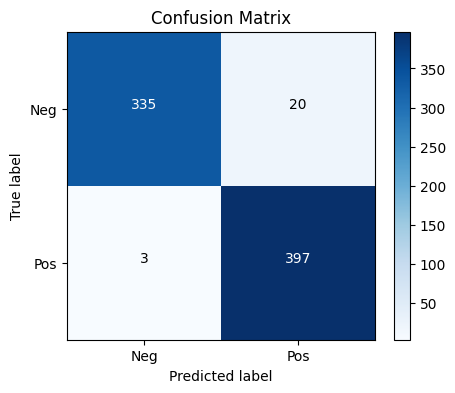

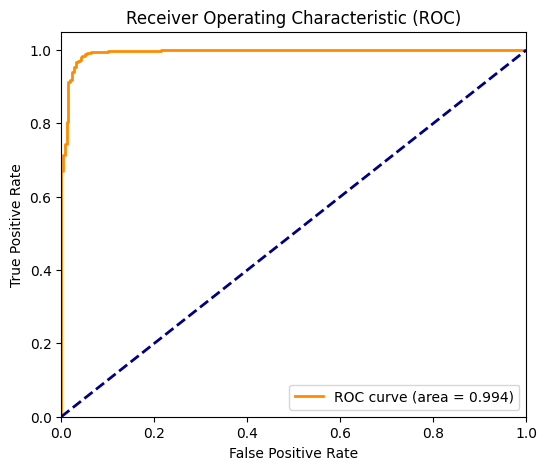

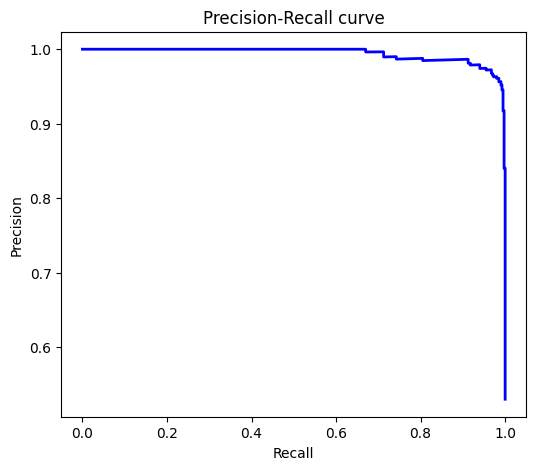

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

classifier_model.eval()
all_preds = []
all_probs = []   # probabilità raw (sigmoid)
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = classifier_model(images)
        probs = torch.sigmoid(outputs)  # probabilità
        preds = probs > 0.28              # predizioni binarie

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).astype(int)
all_labels = np.array(all_labels).astype(int)
all_probs = np.array(all_probs)

# Calcolo TP, TN, FP, FN
TP = ((all_preds == 1) & (all_labels == 1)).sum()
TN = ((all_preds == 0) & (all_labels == 0)).sum()
FP = ((all_preds == 1) & (all_labels == 0)).sum()
FN = ((all_preds == 0) & (all_labels == 1)).sum()

print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# Metriche base
acc = (TP + TN) / (TP + TN + FP + FN + 1e-8)
prec = TP / (TP + FP + 1e-8)
rec = TP / (TP + FN + 1e-8)
f1 = 2 * prec * rec / (prec + rec + 1e-8)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion matrix e heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
plt.title("Confusion Matrix")
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Neg', 'Pos'])
plt.yticks(tick_marks, ['Neg', 'Pos'])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve e AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()
